# Progetto IUM Unito 2024-2025
*Stefanut Cosmin Stoica*


In [ ]:
# Importiamo le lib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.colors import Normalize
from scipy.stats import entropy

In [ ]:
# Percorso shapefile per le mappe
file_path = "./assets/ne_110m_admin_0_countries.shp"

# Caricamento dataset
actors = pd.read_csv("./data/actors.csv")
countries = pd.read_csv("./data/countries.csv")
crew = pd.read_csv("./data/crew.csv")
genres = pd.read_csv("./data/genres.csv")
languages = pd.read_csv("./data/languages.csv")
movies = pd.read_csv("./data/movies.csv")
releases = pd.read_csv("./data/releases.csv")
rotten_tomatoes_review = pd.read_csv("./data/rotten_tomatoes_reviews.csv")
studios = pd.read_csv("./data/studios.csv")
the_oscar_awards = pd.read_csv("./data/the_oscar_awards.csv")



## Pulizia dei dati
---
### Per poter fare analisi su dati consistenti iniziamo a fare una pulizia generale dei dati
#### Prima di tutto togliamo attori che non hanno un nome o che sono duplicati

In [3]:
# Pulizia del dataset actors
nan_in_name = actors["name"].isna().sum()
print(f"Numero di NaN nella colonna 'name': {nan_in_name}")
actors.dropna(subset=["name"],inplace=True)
nan_in_name = actors["name"].isna().sum()
print(f"Numero di NaN nella colonna 'name': {nan_in_name}")

actors.drop_duplicates(subset=["id", "name", "role"],inplace=True)



Numero di NaN nella colonna 'name': 4
Numero di NaN nella colonna 'name': 0


### Dopo di che facciamo una pulizia dei film duplicati
#### Attenzione un film duplicato è un film con tutti i campi uguali eccetto per l'id, non basta il nome

In [4]:
# Id duplicati ma con campi diversi
movies.drop_duplicates(subset=movies.columns.difference(['id']), keep='first',inplace=True)

# Rimuoviamo i duplicati veri e propri
movies.drop_duplicates(subset=["name","date","tagline","description","minute","rating"],inplace=True)

# Contiamo, per farci un'idea, i campi NaN
nan_in_name = movies["name"].isna().sum()
print(f"Numero di NaN nella colonna 'name': {nan_in_name}")

# Estraggo i film con name NaN per vedere se hanno dati validi
movies_with_na_name = movies[movies["name"].isna()]

# Eliminiamo i dati sui film NaN
movies.dropna(subset=["name"],inplace=True)

nan_in_name = movies["name"].isna().sum()
print(f"Numero di NaN nella colonna 'name' dopo la pulizia: {nan_in_name}")

Numero di NaN nella colonna 'name': 5
Numero di NaN nella colonna 'name' dopo la pulizia: 0


In [5]:
movies_with_na_name

,id,name,date,tagline,description,minute,rating
287514,1287515,NaN,2015.0,NaN,NONE is a short film that explores the balance...,4.0,NaN
617642,1617643,NaN,NaN,NaN,NaN,NaN,NaN
646520,1646521,NaN,2008.0,NaN,NaN,NaN,NaN
720294,1720295,NaN,NaN,NaN,"In this directorial debut of Eden Ewardson, he...",8.0,NaN
741481,1741482,NaN,NaN,NaN,NaN,90.0,NaN


### Verifichiamo che le date dei film siano comprese tra il 1888 (anno del primo film) e il 2023; se non lo sono, le rimuoviamo.

In [6]:
valid_dates = movies["date"].dropna()
within_range = valid_dates.between(1888, 2023)

if within_range.all():
    print("Tutti i valori non NaN di 'date' sono tra 1888 e 2023.")
else:
    print("Alcuni valori non NaN di 'date' sono fuori dal range 1888-2023.")

outliers = valid_dates[~within_range]
if outliers.empty:
    print("Nessun valore fuori range.")
else:
    print("Valori non NaN di 'date' fuori range (1888-2023):")
    print(outliers)

Alcuni valori non NaN di 'date' sono fuori dal range 1888-2023.
Valori non NaN di 'date' fuori range (1888-2023):
27        2024.0
74        2024.0
357       2024.0
463       2024.0
473       2024.0
           ...  
940163    2024.0
940164    2024.0
940165    2024.0
940166    2024.0
940167    2024.0
Name: date, Length: 19380, dtype: float64


In [7]:
# Eliminiamo i film fuori dal range 1888-2023
movies.drop(index=movies[~(movies["date"].isna() | movies["date"].between(1888, 2023, inclusive="both"))].index, inplace=True)

### Pulizia dei NaN e duplicati in studios

In [8]:
# Conta NaN
nan_in_studio = studios["studio"].isna().sum()
print(f"Numero di NaN nella colonna 'studio': {nan_in_studio}")

# Deduplica per id e nome studio, tenendo la prima occorrenza
studios.drop_duplicates(subset=["id", "studio"], keep="first", inplace=True)

# Elimina gli studios senza nome
studios.dropna(subset=["studio"], inplace=True)

# Riconta NaN
nan_in_studio = studios["studio"].isna().sum()
print(f"Numero di NaN nella colonna 'studio' dopo la pulizia: {nan_in_studio}")
studios.reset_index(drop=True, inplace=True)

Numero di NaN nella colonna 'studio': 10
Numero di NaN nella colonna 'studio' dopo la pulizia: 0


### Pulizia dei NaN e duplicati in countries

In [9]:
nan_in_country = countries["country"].isna().sum()
print(f"Numero di NaN in 'country': {nan_in_country}")

# Rimuove duplicati stessi id/country
countries.drop_duplicates(subset=["id", "country"], keep="first", inplace=True)

# Elimina righe senza country
countries.dropna(subset=["country"], inplace=True)

nan_in_country = countries["country"].isna().sum()
print(f"Numero di NaN in 'country' dopo la pulizia: {nan_in_country}")
countries.reset_index(drop=True, inplace=True)

Numero di NaN in 'country': 0
Numero di NaN in 'country' dopo la pulizia: 0


### Pulizia dei duplicati in oscar awards

In [10]:
the_oscar_awards.drop_duplicates()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10884,2023,2024,96,WRITING (Original Screenplay),Written by Celine Song,Past Lives,False
10885,2023,2024,96,JEAN HERSHOLT HUMANITARIAN AWARD,NaN,NaN,True
10886,2023,2024,96,HONORARY AWARD,"To Angela Bassett, who has inspired audiences ...",NaN,True
10887,2023,2024,96,HONORARY AWARD,"To Mel Brooks, for his comedic brilliance, pro...",NaN,True


### Pulizia dei duplicati in releases

In [11]:
releases.drop_duplicates(subset=["id","country","date","type","rating"])

,id,country,date,type,rating
0,1000001,Andorra,2023-07-21,Theatrical,NaN
1,1000001,Argentina,2023-07-20,Theatrical,ATP
2,1000001,Australia,2023-07-19,Theatrical,PG
3,1000001,Australia,2023-10-01,Digital,PG
4,1000001,Austria,2023-07-20,Theatrical,NaN
...,...,...,...,...,...
1332777,1940967,USA,1909-01-01,Theatrical,NaN
1332778,1940968,Sweden,1908-11-11,Theatrical,NaN
1332779,1940969,France,1902-01-01,Theatrical,NaN
1332780,1940970,France,1902-01-01,Theatrical,NaN


# ANALISI

## Analisi 1 - Crescita del cinema nel tempo e distribuzione geografica
### Quali sono i paesi che hanno prodotto più film durante l'intera storia cinematografica?

Obiettivo:
1) Misurare come cambia la produzione cinematografica nel tempo (film/anno).
2) Capire come la produzione è distribuita tra i paesi (concentrazione).
3) Produrre una mappa mondiale (choropleth) usando Natural Earth (`ne_110m_admin_0_countries.shp`).
4) Ripetere la mappa per decenni per vedere l’evoluzione geografica.



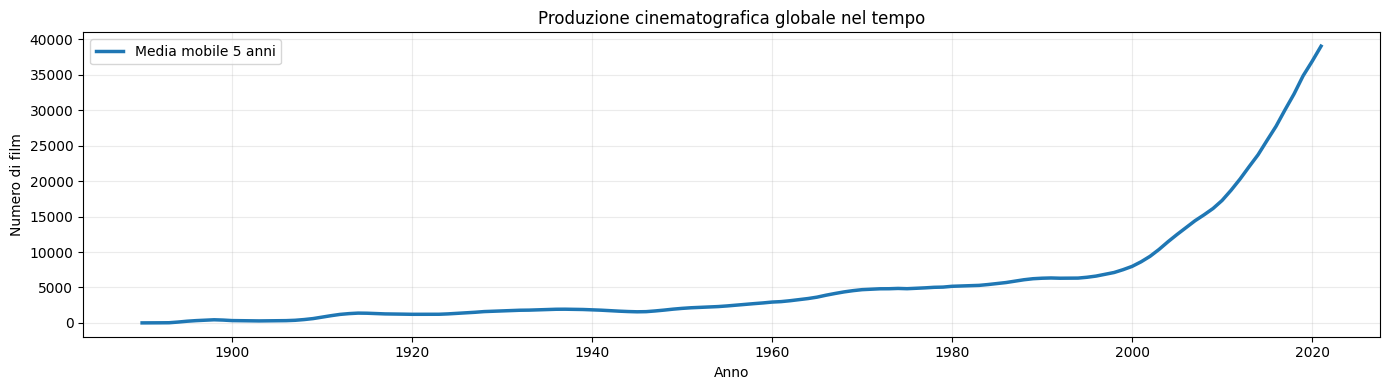

In [12]:
# Movies con date valide, not NaN
movies_time = (
    movies.dropna(subset=["date"])
          .assign(year=lambda df: df["date"].astype(int))
)

movies_per_year = (
    movies_time.groupby("date")
               .size()
               .reset_index(name="n_movies")
               .sort_values("date")
)

# Media mobile (5 anni)
movies_per_year["ma_5"] = movies_per_year["n_movies"].rolling(window=5, center=True).mean()

plt.figure(figsize=(14, 4))
plt.plot(movies_per_year["date"], movies_per_year["ma_5"], linewidth=2.5, label="Media mobile 5 anni")
plt.title("Produzione cinematografica globale nel tempo")
plt.xlabel("Anno")
plt.ylabel("Numero di film")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

#### Qui possiamo vedere come ovviamente con l'avanzare del tempo l'industria ha iniziato ad espandersi, dovuto a motivi culturali e tecnici che hanno favorito la nascita e sviluppo di questo nuovo settore. 
#### Andiamo in seguito ad analizzare i paesi che più hanno contribuito a questo sviluppo

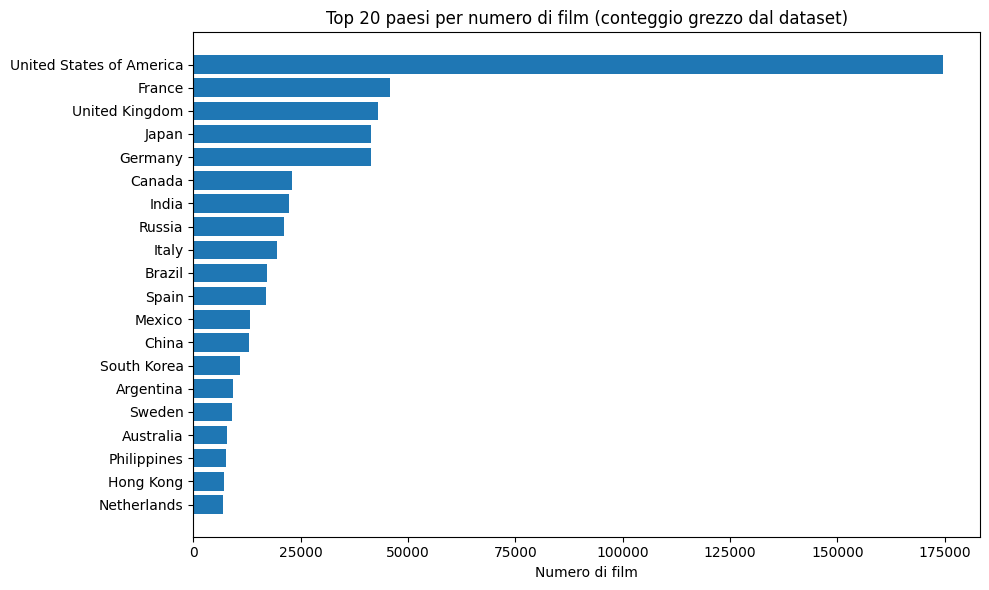

In [80]:
## Merging fra countries e movies per avere il conteggio dei film per paese

# servirà dopo
COUNTRY_REPLACE = {
    "USA": "United States of America",
    "UK": "United Kingdom",
    "UAE": "United Arab Emirates",
    "USSR": "Russia",
    "Russian Federation": "Russia",
    "Soviet Union": "Russia",
    "Czechoslovakia": "Czech Republic",
    "Yugoslavia": "Serbia",
    "Bolivarian Republic of Venezuela": "Venezuela",
    "Democratic Republic of Congo": "Dem. Rep. Congo",
    "Central African Republic": "Central African Rep.",
    "South Sudan": "S. Sudan",
    "United Republic of Tanzania": "Tanzania",
    "Dominican Republic": "Dominican Rep.",
    "Ivory Coast" : "Côte d'Ivoire",
    "Lao People's Democratic Republic" : "Laos"
}

# Sostituiamo qui
countriesToReplace = countries.replace(COUNTRY_REPLACE)

movies_by_country = (
    countriesToReplace.groupby("country")
                   .size()
                   .reset_index(name="n_movies")
                   .sort_values("n_movies", ascending=False)
)

topN = 20
top_c = movies_by_country.head(topN).sort_values("n_movies", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_c["country"], top_c["n_movies"])
plt.title(f"Top {topN} paesi per numero di film (conteggio grezzo dal dataset)")
plt.xlabel("Numero di film")
plt.tight_layout()
plt.show()


#### Come aspettato il primo posto spetta agli states essendo infatti il paese che più ha prodotti film in tutto il globo. Questo è dovuto ad una forte industria sempre in espansione, a motivi culturali come banalmente la lingua e i tanti investimenti privati e statali
#### Andiamo in seguito a produrre una heatmap con visualizzazione di una mappa per avere un'idea più chiara

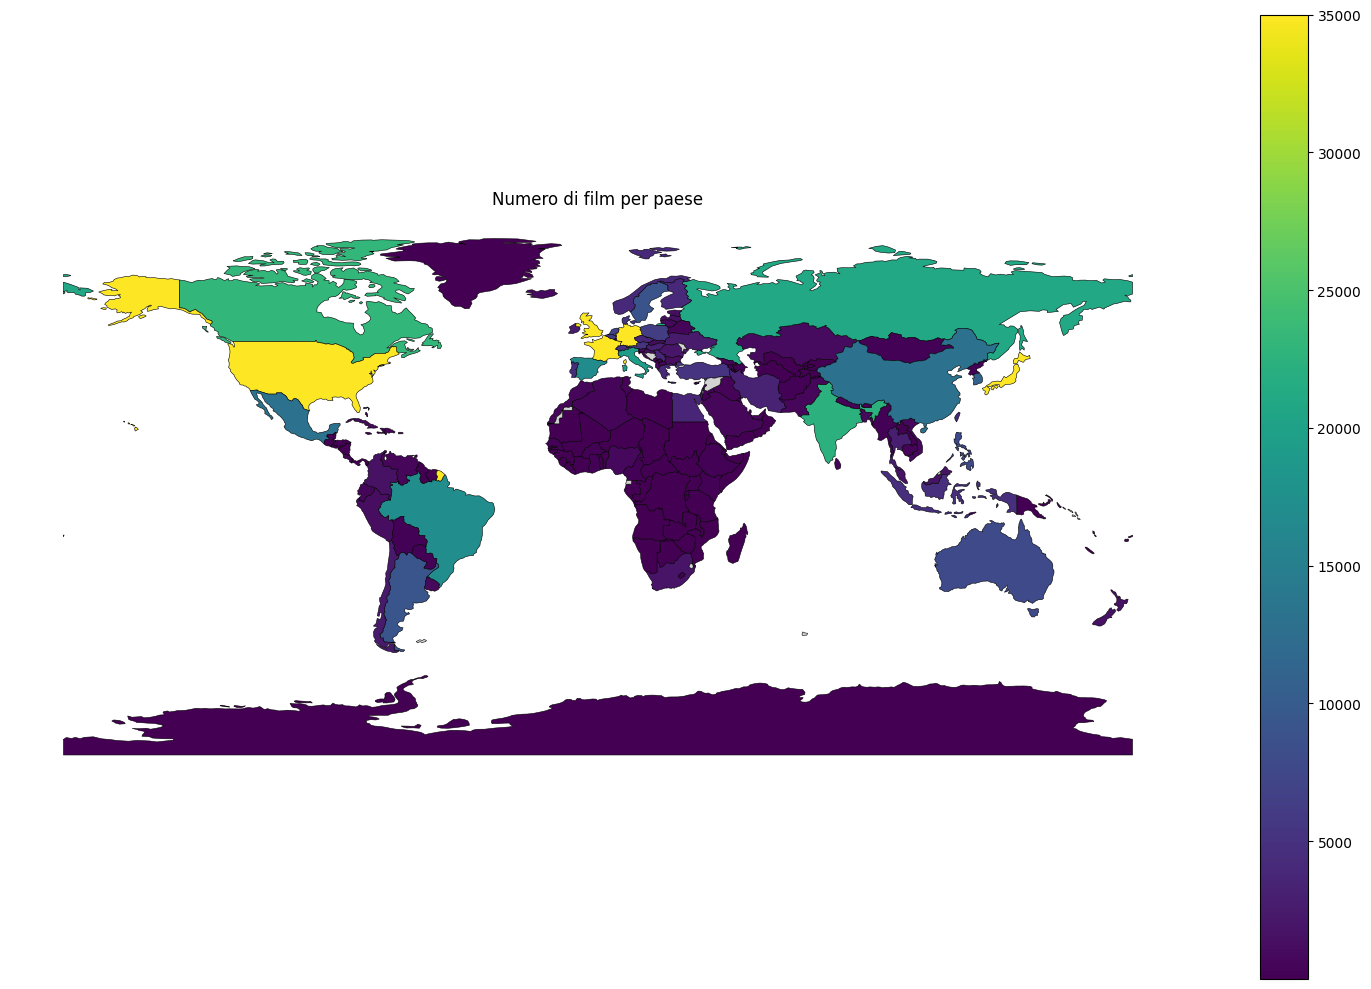

,NAME,ISO_A3
92,Laos,LAO


In [ ]:
world = gpd.read_file(file_path)
CAP = 35000

# Risolviamo i conflitti
world["merge_country"] = world["NAME"].replace({
    "Somaliland": "Somalia"
})

# Sostituiamo anche nella mappa
merged_map = world.merge(
    movies_by_country,
    left_on="merge_country",
    right_on="country",
    how="left"
)

# Riempie i NaN con 0 perchè quei paesi non hanno film associati
merged_map["n_movies"] = merged_map["n_movies"].fillna(0)

# Per la visualizzazione limitiamo il numero massimo di film a CAP e sostituiamo 0 con NaN per avere un colore diverso
merged_map["n_movies_viz"] = (
    merged_map["n_movies"]
    .clip(upper=CAP)
    .replace(0, np.nan)
)

# Normalizzazione per la mappa perchè i valori sono molto distanti tra loro
norm = Normalize(vmin=1, vmax=CAP)

fig, ax = plt.subplots(figsize=(15, 10))
merged_map.plot(
    column="n_movies_viz",
    cmap="viridis",
    norm=norm,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "0 film"},
    edgecolor="black",
    linewidth=0.4
)

ax.set_title("Numero di film per paese")
ax.set_axis_off()
plt.tight_layout()
plt.show()




#### Questa mappa suggerisce una maggiore concentrazione della produzione cinematografica nei paesi occidentali, in particolare negli Stati Uniti e in Europa occidentale. Fanno eccezione il Giappone, che ha mostrato un significativo incremento produttivo negli ultimi decenni, e l’India, la cui elevata produzione è fortemente sostenuta dall’industria cinematografica di Bollywood.
#### E' tuttavia importante non interpretare questa rappresentazione come una misura assoluta della reale quantità di film prodotti da ciascun paese. Il risultato è infatti influenzato da bias di catalogazione: numerose produzioni, in particolare in paesi come la Cina, Brasile, o Russia, rimangono confinate al mercato interno e non vengono sempre registrate nei principali database internazionali. Contro ogni previsione il Nord Korea produce film.

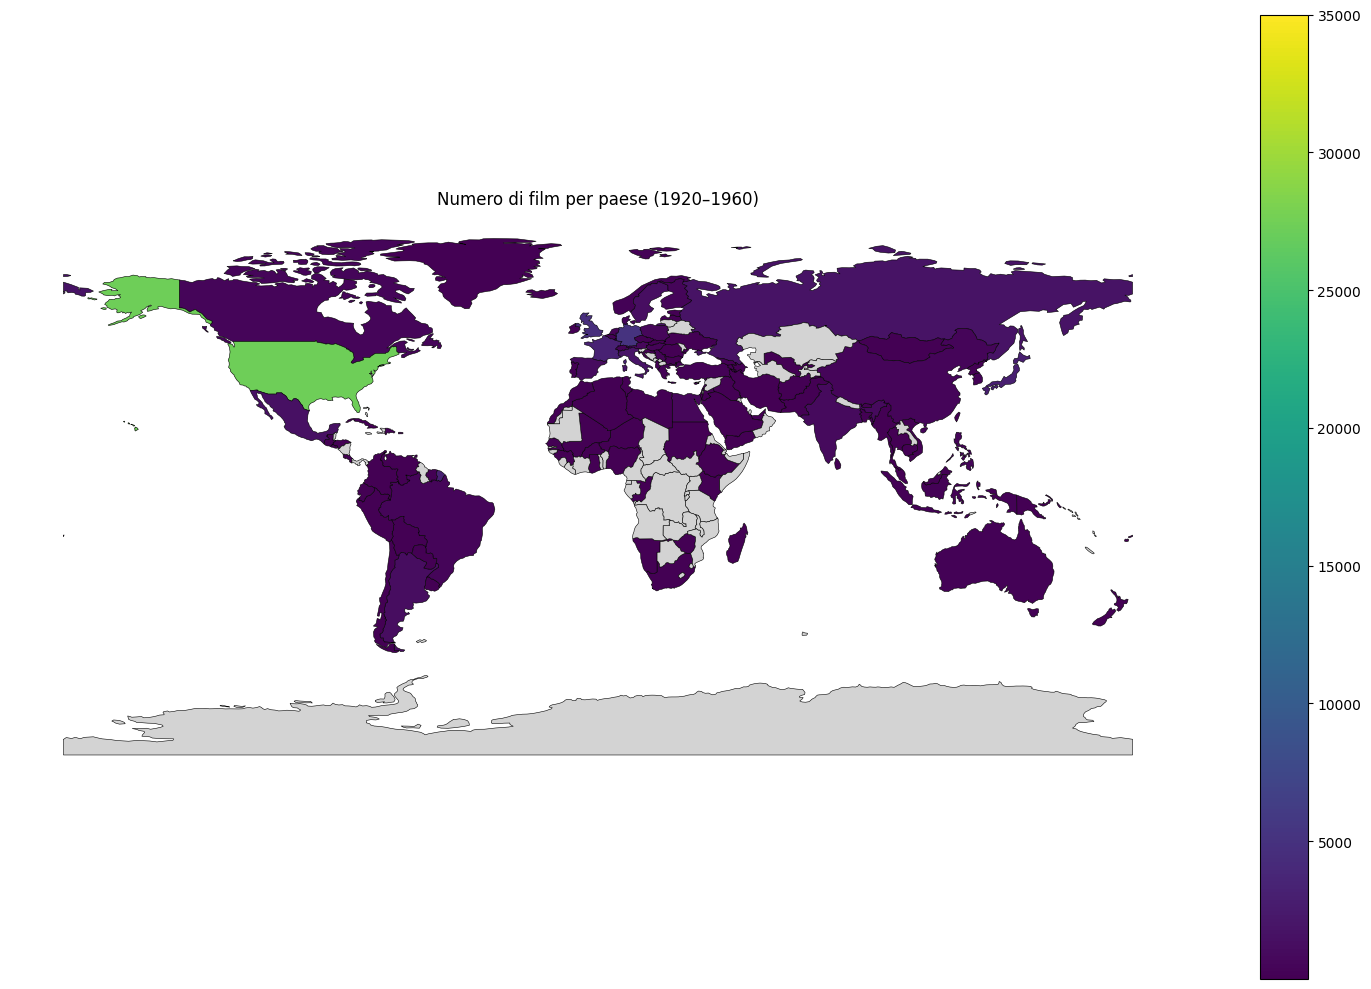

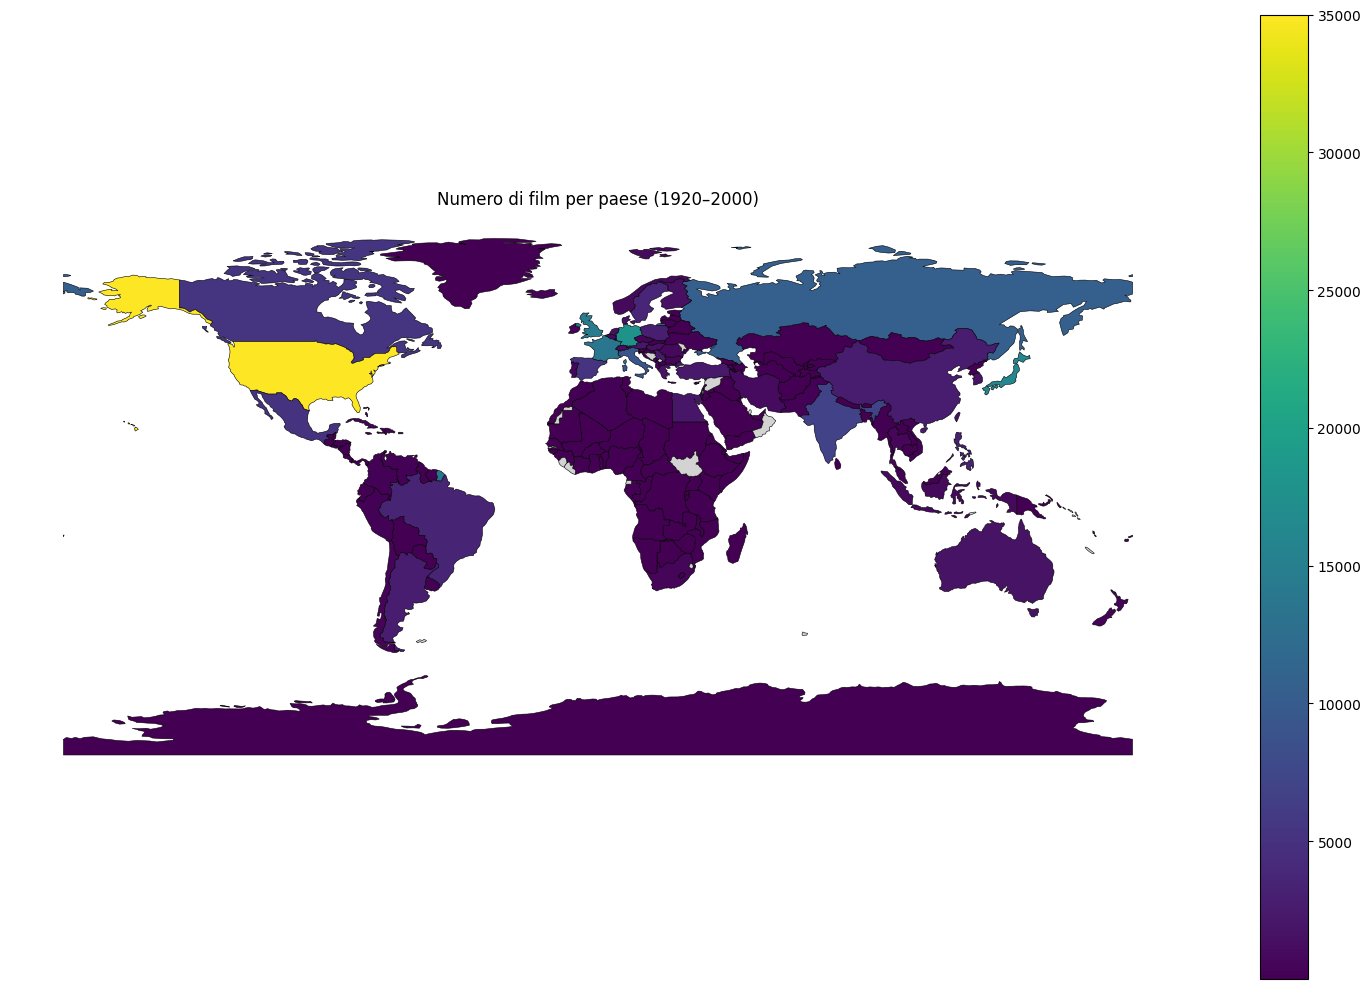

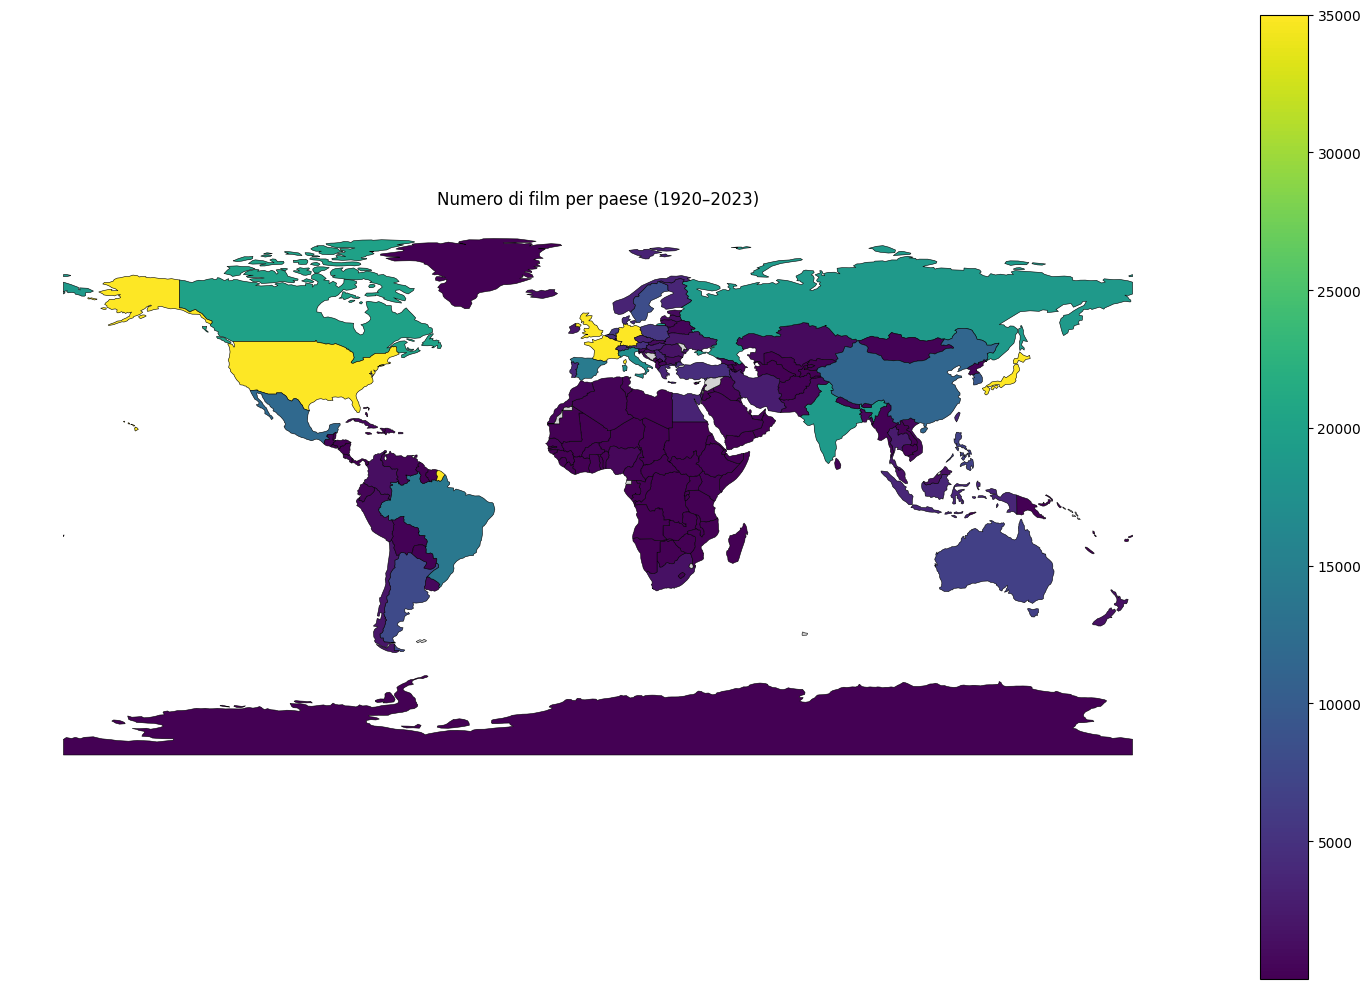

In [87]:
# Mappa per periodi
periods = [
    (1920, 1960),
    (1920, 2000),
    (1920, 2023),
]

# Per ogni periodo, creiamo la mappa
for start_year, end_year in periods:

    # Filtriamo i film per il periodo
    movies_period = movies[
        (movies["date"] >= start_year) &
        (movies["date"] < end_year)
    ]

    movies_period_countries = movies_period.merge(
        countriesToReplace,
        on="id",
        how="inner"
    )

    # Conteggiamo i film per paese nel periodo
    movies_by_country_period = (
        movies_period_countries
        .groupby("country")
        .size()
        .reset_index(name="n_movies")
    )

    merged_map = world.merge(
        movies_by_country_period,
        left_on="merge_country", 
        right_on="country",
        how="left"
    )

    merged_map["n_movies"] = merged_map["n_movies"].fillna(0)

    # Per la visualizzazione limitiamo il numero massimo di film a CAP e sostituiamo 0 con NaN per avere un colore diverso
    merged_map["n_movies_viz"] = (
        merged_map["n_movies"]
        .clip(upper=CAP)
        .replace(0, np.nan)
    )

    norm = Normalize(vmin=1, vmax=CAP)

    fig, ax = plt.subplots(figsize=(15, 10))
    merged_map.plot(
        column="n_movies_viz",
        cmap="viridis",
        norm=norm,
        ax=ax,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "0 film"},
        edgecolor="black",
        linewidth=0.4
    )

    ax.set_title(f"Numero di film per paese ({start_year}–{end_year})")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()



Le mappe per periodo mostrano come la produzione cinematografica mondiale sia cambiata nel tempo, passando da una forte concentrazione geografica a una distribuzione più ampia.

Nel periodo **1920–1960** la produzione è quasi interamente concentrata negli Stati Uniti e in pochi paesi europei. Questo riflette la nascita dell’industria cinematografica moderna e la limitata diffusione dei mezzi di produzione nel resto del mondo.

Nel periodo **1960–2000** si osserva un’espansione significativa: oltre agli Stati Uniti emergono l’Europa occidentale, il Giappone e l’area sovietica. In questa fase si sviluppano numerosi cinema nazionali, spesso sostenuti da politiche culturali statali.

Nel periodo **2000–2023** la produzione risulta più globalizzata. Restano dominanti gli Stati Uniti, ma crescono in modo evidente paesi come India, Cina, Brasile e Corea del Sud, sostenuti da grandi mercati interni e da industrie cinematografiche locali.


## Analisi 2 – Evoluzione e diversificazione dei generi cinematografici nel tempo
### Come sono cambiati i generi cinematografici e quanto si sono diversificati nel corso degli anni?

Obiettivo:
1) Analizzare come varia la composizione dei generi cinematografici nel tempo.
2) Misurare il peso relativo dei diversi generi per decennio.
3) Osservare l’emergere e il declino dei principali generi cinematografici.
4) Quantificare il livello di diversità dei generi prodotti in ciascun periodo.

### Iniziamo facendo un merge sensato fra movies e genres e suddividendoli per decadi

In [88]:
movies_with_generes = (
    movies[["id", "date"]]
    .merge(genres, on="id", how="inner")
)

movies_with_generes = movies_with_generes.dropna(subset=["date", "genre"])

# Convertiamo la colonna "date" in numerica, gestendo gli errori
movies_with_generes["year"] = pd.to_numeric(movies_with_generes["date"], errors="coerce")
movies_with_generes = movies_with_generes.dropna(subset=["year"])

movies_with_generes["year"] = movies_with_generes["year"].astype(int)

# Creiamo la colonna "decade" come decade di appartenenza per ogni film perchè ci servirà dopo
movies_with_generes["decade"] = (movies_with_generes["year"] // 10) * 10
movies_with_generes["genre"] = movies_with_generes["genre"].str.strip()

movies_with_generes.head()


,id,date,genre,year,decade
0,1000001,2023.0,Comedy,2023,2020
1,1000001,2023.0,Adventure,2023,2020
2,1000002,2019.0,Comedy,2019,2010
3,1000002,2019.0,Thriller,2019,2010
4,1000002,2019.0,Drama,2019,2010


### Creiamo un dataset percentuale per decade indicando il genere e il numero di film creati

In [89]:
# Creiamo il dataset con il conteggio dei film per genere e decade
genre_decade = (
    movies_with_generes
    .groupby(["decade", "genre"])
    .size()
    .reset_index(name="n_movies")
)

# Creiamo un dataset percentuale
genre_decade_pct = (
    genre_decade
    .assign(
        pct=lambda x: x["n_movies"] /
        x.groupby("decade")["n_movies"].transform("sum")
    )
)

genre_decade_pct.head()


,decade,genre,n_movies,pct
0,1880,Documentary,7,1.000000
1,1890,Action,9,0.005925
2,1890,Animation,9,0.005925
3,1890,Comedy,157,0.103357
4,1890,Crime,11,0.007242


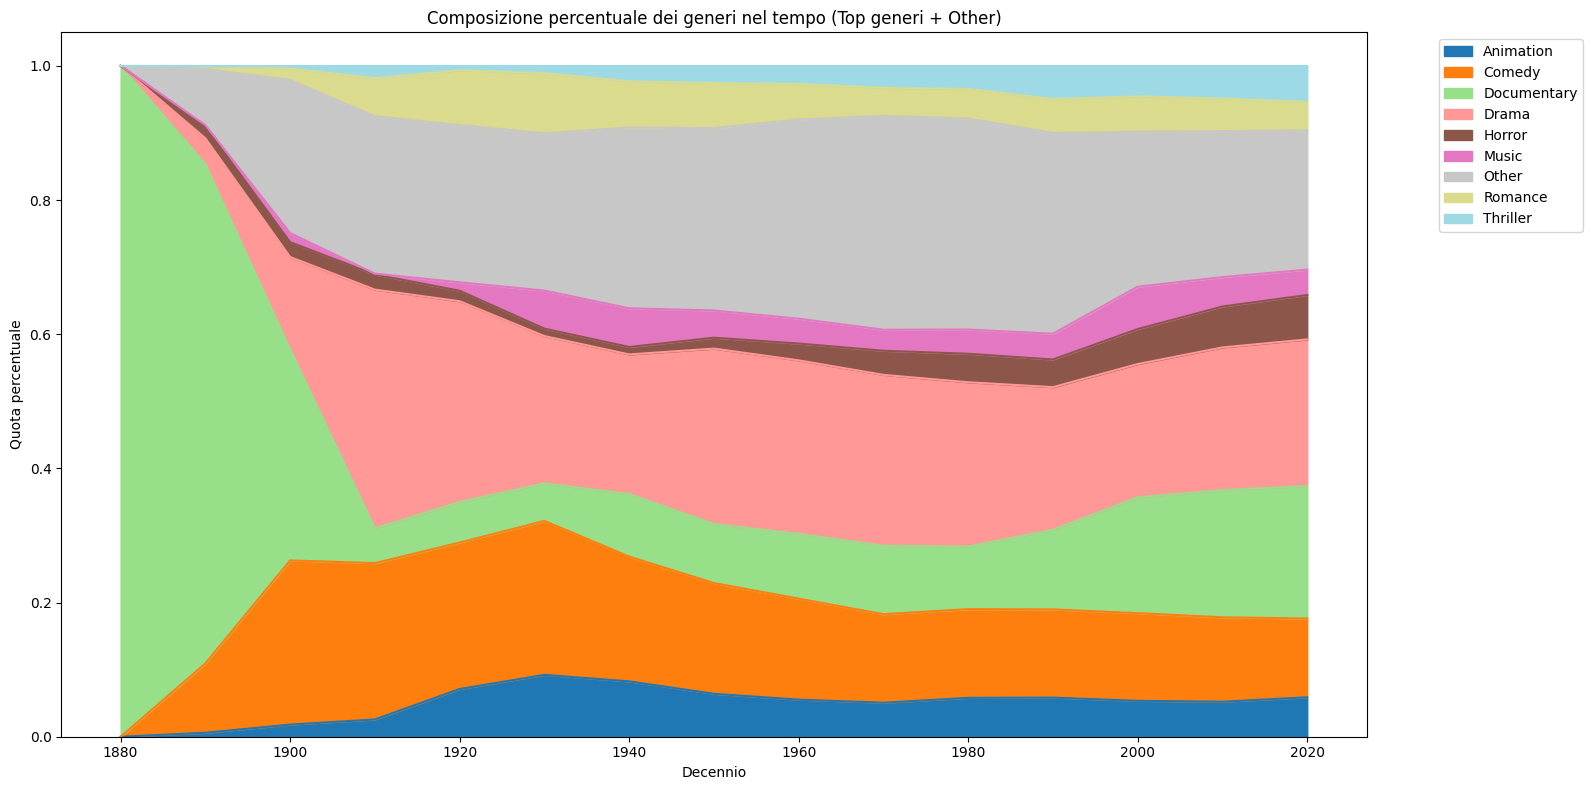

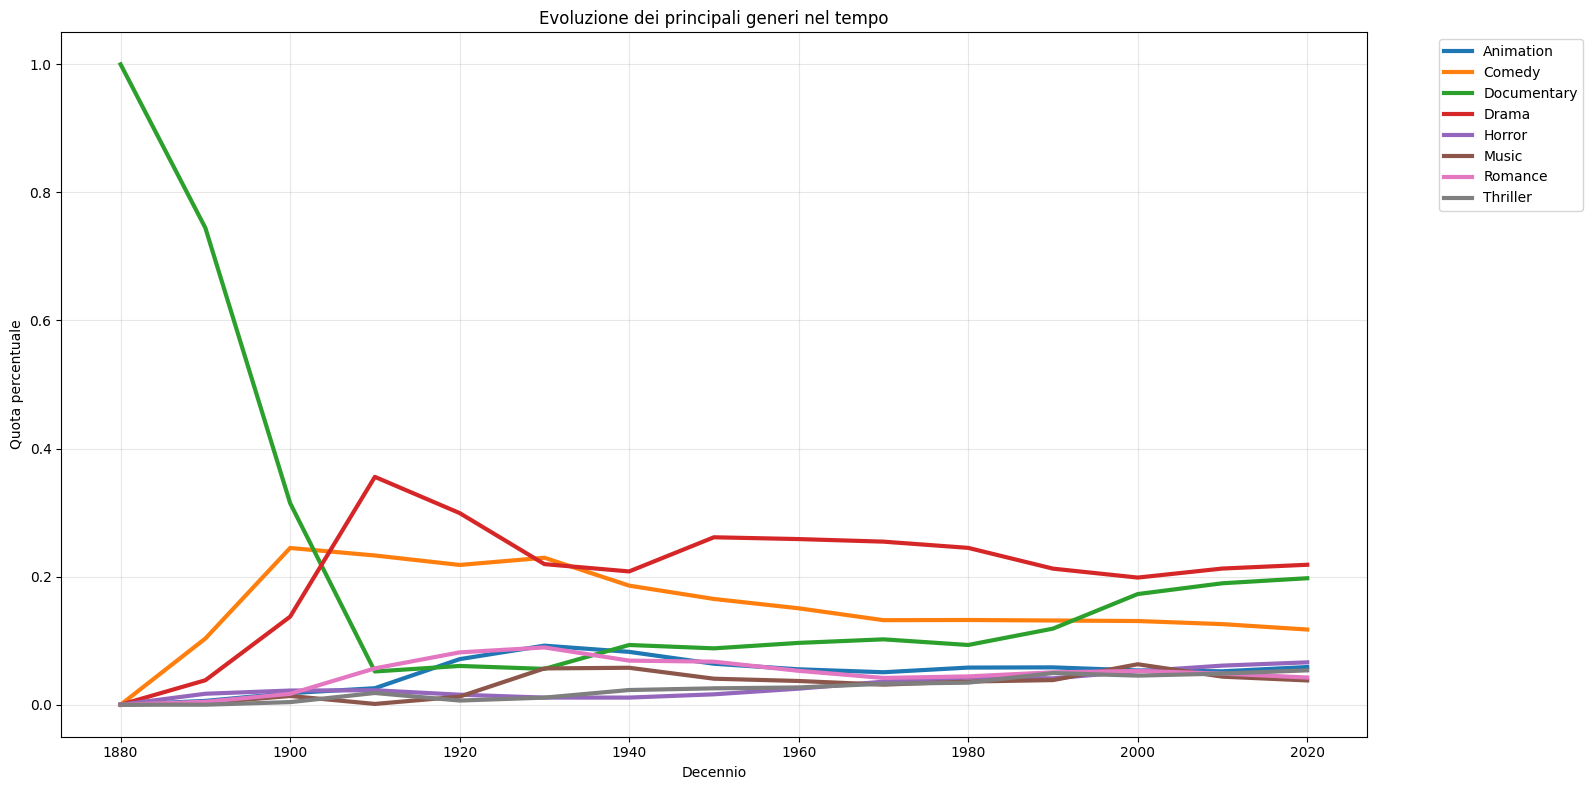

In [90]:
# Visualizziamo la composizione percentuale dei generi nel tempo (tutti i generi)
MAX_TOP_N = 8

top_genres = (
    genre_decade
    .groupby("genre")["n_movies"]
    .sum()
    .sort_values(ascending=False)
    .head(MAX_TOP_N)
    .index
)

# Creiamo una copia del dataset percentuale e raggruppiamo i generi non top in "Other"
genre_decade_pct_top = genre_decade_pct.copy()
genre_decade_pct_top["genre"] = genre_decade_pct_top["genre"].where(
    genre_decade_pct_top["genre"].isin(top_genres),
    "Other"
)


pivot_all_top = (
    genre_decade_pct_top
    .groupby(["decade", "genre"])["pct"]
    .sum()
    .reset_index()
    .pivot(index="decade", columns="genre", values="pct")
    .fillna(0)
)

pivot_all_top.plot(
    kind="area",
    figsize=(16, 8),
    colormap="tab20"
)

plt.title("Composizione percentuale dei generi nel tempo (Top generi + Other)")
plt.xlabel("Decennio")
plt.ylabel("Quota percentuale")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


pivot_top = (
    pivot_all_top
    .drop(columns="Other", errors="ignore")
)

pivot_top.plot(figsize=(16, 8), linewidth=3)

plt.title("Evoluzione dei principali generi nel tempo")
plt.xlabel("Decennio")
plt.ylabel("Quota percentuale")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Nei primi decenni l’enorme quota di **Documentary** riflette il cinema come semplice tecnologia di registrazione della realtà.

A partire dagli anni 1910 il **Drama** diventa il genere dominante e mantiene un ruolo centrale per tutta la storia del cinema, senza mai scomparire.

La **Comedy** agisce come genere di transizione: cresce rapidamente nei primi anni (cinema muto, Chaplin) e poi diminuisce pur continuando a crescere.

L’aumento della categoria **Other** indica una progressiva frammentazione del cinema, con la nascita e la coesistenza di numerosi generi e sottogeneri specializzati.


#### Quanto è vario il cinema in questo periodo?

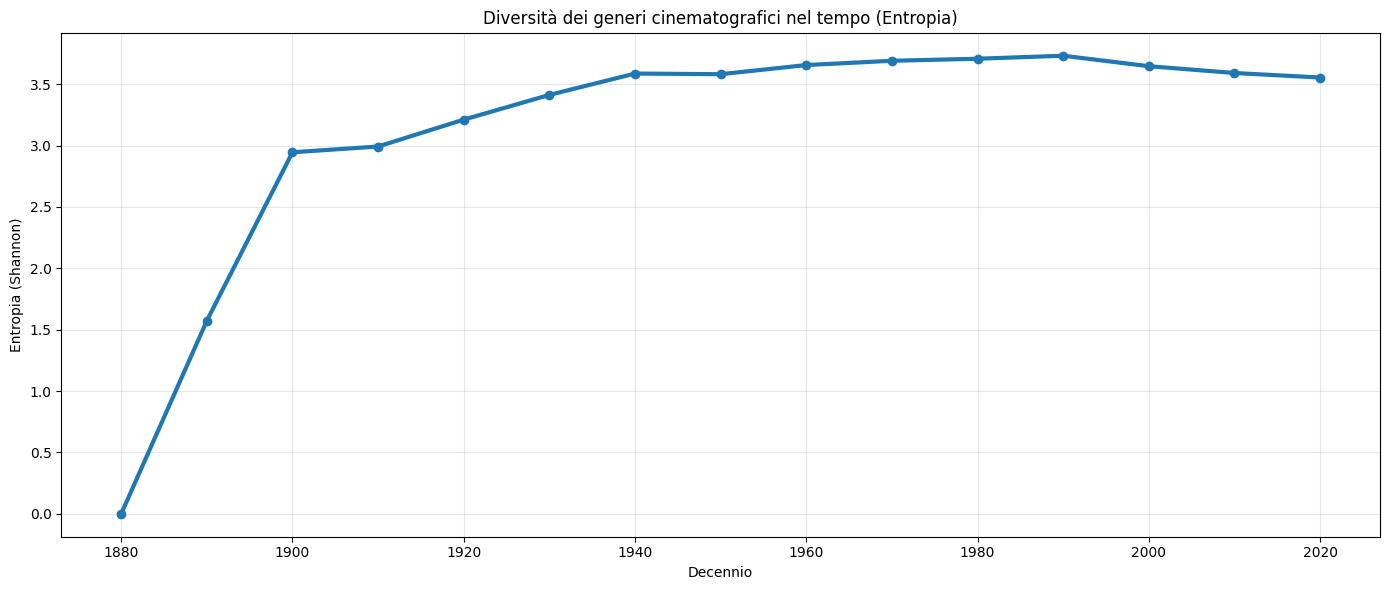

In [91]:
# Diversità dei generi nel tempo (Entropia di Shannon)
# Calcoliamo l'entropia di Shannon per ogni decade
# Doc : https://maddmaths.simai.eu/divulgazione/rubriche/la-lente-matematica/entropia-di-shannon/

entropy_by_decade = (
    genre_decade_pct
    .groupby("decade")["pct"]
    .apply(lambda s: entropy(s, base=2))
    .reset_index(name="genre_entropy")
)

plt.figure(figsize=(14, 6))

plt.plot(
    entropy_by_decade["decade"],
    entropy_by_decade["genre_entropy"],
    marker="o",
    linewidth=3
)

plt.title("Diversità dei generi cinematografici nel tempo (Entropia)")
plt.xlabel("Decennio")
plt.ylabel("Entropia (Shannon)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Questo grafico mostra l’evoluzione della diversità dei generi cinematografici nel tempo, misurata tramite l’entropia di Shannon. Valori bassi indicano una forte concentrazione su pochi generi, mentre valori più alti corrispondono a una distribuzione più equilibrata tra generi diversi.

L’aumento dell’entropia nei primi decenni segnala il passaggio da un cinema inizialmente semplice a un sistema sempre più articolato. Sccessivamente abbiamo una fase di maturità, in cui coesistono stabilmente molti generi differenti.


## Analisi 3 – Oscar Distortion Index  
### Quanto gli Oscar “mentono” rispetto al pubblico e alla critica


Obiettivo
1) Confrontare il numero di Oscar vinti con la qualità critica dei film premiati.
2) Individuare generi cinematografici sistematicamente sovra-premiati o sotto-premiati.
3) Quantificare la distanza tra riconoscimento Oscar e giudizio critico.
4) Costruire un indicatore sintetico di distorsione: **Oscar Distortion Index (ODI)**.


### Prima ci costruiamo gli oscar piu vinti per genere

In [92]:
# Merge di movies con the_oscar_awards
countries_oscar_awards = pd.merge(
    movies,
    the_oscar_awards,
    left_on=["name", "date"],
    right_on=["film", "year_film"],
    how="inner"
)

# Merge di countries_oscar_awards con countries
countries_oscar_awards = pd.merge(
    countries_oscar_awards,
    genres,
    on="id",
    how="inner"
)

# Raggruppiamo per film e aggregiamo i generi in una lista separata da virgole
countries_oscar_awards = (
    countries_oscar_awards
    .groupby(
        [
            "id",
            "date",
            "film",
            "year_film",
            "winner",
        ],
        as_index=False
    )
    .agg({
        "genre": lambda x: ", ".join(sorted(set(x)))
    })
)

# Filtriamo i film che hanno vinto un Oscar
countries_oscar_awards_winners = countries_oscar_awards[countries_oscar_awards['winner'] == True]

# Contiamo il numero di Oscar per genere
oscar_counts = countries_oscar_awards_winners['genre'].value_counts()

# Splittiamo i generi in liste
genres_exploded = (
    countries_oscar_awards_winners
    .assign(genre=countries_oscar_awards_winners["genre"].str.split(", "))
    .explode("genre")
)

# Contiamo Oscar per singolo genere
oscar_counts = genres_exploded["genre"].value_counts()

oscar_counts


genre
Drama              673
Romance            307
Comedy             262
Adventure          141
Documentary        139
History            133
Music              119
Animation          110
War                107
Thriller           104
Action             102
Family              89
Crime               80
Fantasy             73
Science Fiction     55
Mystery             35
Western             35
Horror              23
TV Movie             3
Name: count, dtype: int64

#### Grafico

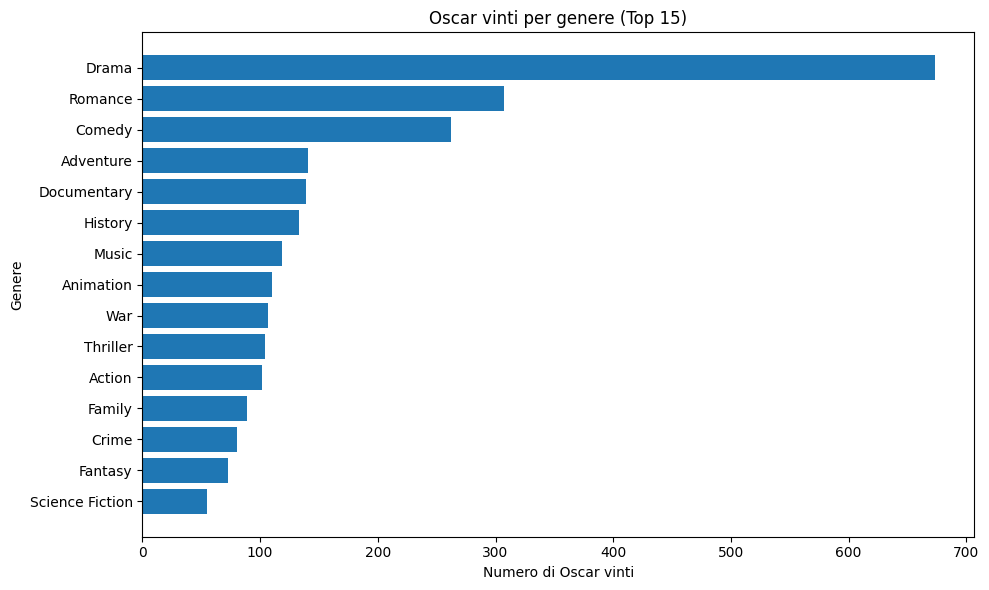

In [93]:

# Prendiamo solo i top 15 generi per leggibilità
top_n = 15
oscar_top = oscar_counts.head(top_n).sort_values()

plt.figure(figsize=(10, 6))
plt.barh(oscar_top.index, oscar_top.values)
plt.xlabel("Numero di Oscar vinti")
plt.ylabel("Genere")
plt.title("Oscar vinti per genere (Top 15)")
plt.tight_layout()
plt.show()


#### Adesso facciamo un merge con le recensioni di rotten tomatoes

In [94]:
# abbiamo oscar_top
base = countries_oscar_awards_winners.copy()

merged = pd.merge(
    base,
    rotten_tomatoes_review,
    left_on="film",
    right_on="movie_title",
    how="inner"
)


merged.drop(columns=["rotten_tomatoes_link", "movie_title", "critic_name", "publisher_name", "review_score", "review_date", "review_content"], inplace=True)

merged.head()


,id,date,film,year_film,winner,genre,top_critic,review_type
0,1000002,2019.0,Parasite,2019,True,"Comedy, Drama, Thriller",False,Fresh
1,1000002,2019.0,Parasite,2019,True,"Comedy, Drama, Thriller",True,Rotten
2,1000002,2019.0,Parasite,2019,True,"Comedy, Drama, Thriller",False,Rotten
3,1000002,2019.0,Parasite,2019,True,"Comedy, Drama, Thriller",False,Rotten
4,1000002,2019.0,Parasite,2019,True,"Comedy, Drama, Thriller",False,Rotten


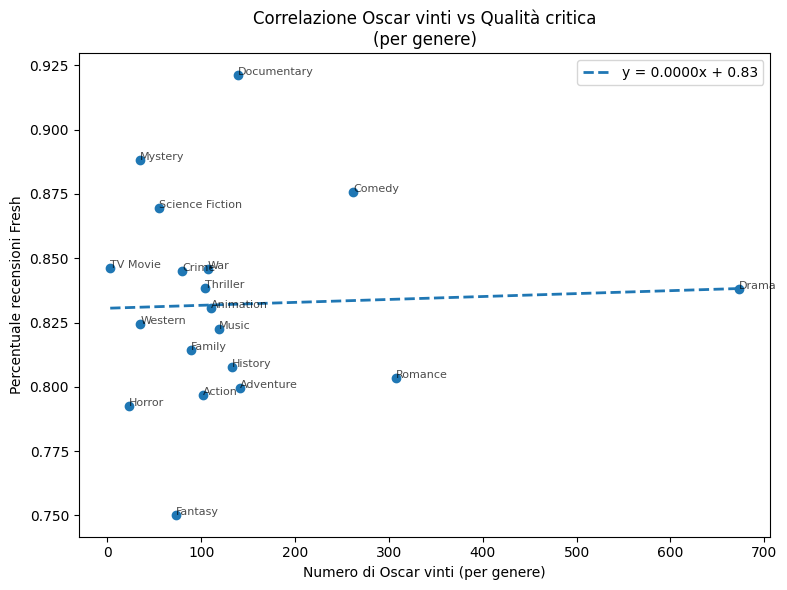

In [95]:
# Partiamo dal merged (film vincitori + recensioni)
df = merged.copy()

# Espandiamo i generi
df = df.assign(genre=df["genre"].str.split(", "))
df = df.explode("genre")

# Teniamo solo Fresh / Rotten
df = df[df["review_type"].isin(["Fresh", "Rotten"])]

# Percentuale Fresh per genere
fresh_rate = (
    df
    .groupby("genre")["review_type"]
    .apply(lambda x: (x == "Fresh").mean())
    .rename("fresh_rate")
)

# Oscar per singolo genere
oscar_per_genre = (
    genres_exploded["genre"]
    .value_counts()
    .rename("oscar_count")
)


analysis_df = pd.concat(
    [oscar_per_genre, fresh_rate],
    axis=1
).dropna()

x = analysis_df["oscar_count"].values
y = analysis_df["fresh_rate"].values

# Regressione lineare (y = m*x + q)
m, q = np.polyfit(x, y, 1)

# Valori per la retta
x_line = np.linspace(x.min(), x.max(), 100)
y_line = m * x_line + q

plt.figure(figsize=(8, 6))

# Scatter
plt.scatter(x, y)

# Etichette dei generi
for genre, row in analysis_df.iterrows():
    plt.text(
        row["oscar_count"],
        row["fresh_rate"],
        genre,
        fontsize=8,
        alpha=0.7
    )

# Retta di regressione
plt.plot(
    x_line,
    y_line,
    linestyle="--",
    linewidth=2,
    label=f"y = {m:.4f}x + {q:.2f}"
)

plt.xlabel("Numero di Oscar vinti (per genere)")
plt.ylabel("Percentuale recensioni Fresh")
plt.title("Correlazione Oscar vinti vs Qualità critica\n(per genere)")
plt.legend()
plt.tight_layout()
plt.show()


Da questo grafico notiamo subito che la percentuale di recensioni Fresh non cambia in modo apprezzabile all'aumentare dell'Oscar, anzi, la linea di regressione è praticamente piatta.
Questo ci sta ad indicare che non esiste una correlazione neanche minima fra recensioni ed oscar premiati.
Un caso è per esempio Documentary, che ottiene buonissime recensioni ma pochissimi oscar, al contrario di Drama che ottiene recensioni più modeste ma rimane il genere più premiato.
Romance invece totalizza recensioni peggiori di Drama e Documentary ma rimane comunque il secondo genere più premiato 
L’analisi mostra un’assenza di correlazione significativa tra il numero di Oscar vinti da un genere e la percentuale di recensioni positive. La qualità critica risulta relativamente stabile tra i generi, indipendentemente dal successo agli Oscar, suggerendo che il premio non è un buon indicatore dell’apprezzamento critico

## Analisi 4 – Crew Signature Analysis  
### Esiste una “firma invisibile” dei ruoli tecnici nel cinema?

Obiettivo 
1) Verificare se alcuni **ruoli tecnici non autoriali** (Editor, Cinematography, Set Decoration, Camera Operator) presentano pattern sistematici di qualità nei film a cui partecipano.  
2) Misurare il contributo dei ruoli tecnici in termini di:
   - **qualità media** dei film (rating medio)
   - **affidabilità del risultato** (varianza del rating).  
3) Distinguere tra ruoli che:
   - aumentano il **potenziale massimo** di un film  
   - riducono il **rischio di risultati negativi**.  
4) Confrontare le “firme statistiche” dei diversi ruoli tecnici all’interno di uno **spazio qualità–affidabilità condiviso**.

L’analisi non mira a stilare classifiche di merito individuali, ma a individuare **pattern strutturali** che suggeriscano l’esistenza di una *firma invisibile* associata ai ruoli tecnici nella produzione cinematografica.


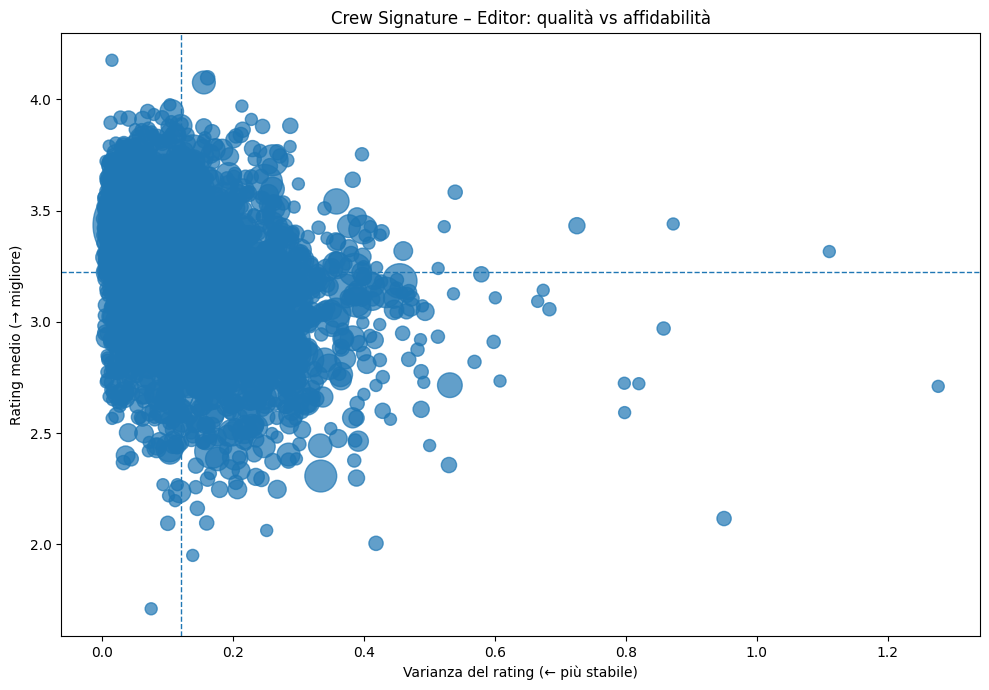

In [96]:
crew_movies = (
    crew
    .merge(movies[["id", "rating", "date"]], on="id", how="inner")
)

editors = crew_movies[crew_movies["role"] == "Editor"]

editor_signature = (
    editors
    .groupby("name")
    .agg(
        n_films=("rating", "count"),
        mean_rating=("rating", "mean"),
        var_rating=("rating", "var")
    )
    .reset_index()
)


# Filtra solo editor con abbastanza film 
MIN_FILMS = 5
sig = editor_signature[editor_signature["n_films"] >= MIN_FILMS]

plt.figure(figsize=(10, 7))

plt.scatter(
    sig["var_rating"],
    sig["mean_rating"],
    s=sig["n_films"] * 15, # Dimensione punti in base al numero di film
    alpha=0.7
)

plt.xlabel("Varianza del rating (← più stabile)")
plt.ylabel("Rating medio (→ migliore)")
plt.title("Crew Signature – Editor: qualità vs affidabilità")

# Linee di riferimento
plt.axhline(sig["mean_rating"].mean(), linestyle="--", linewidth=1)
plt.axvline(sig["var_rating"].mean(), linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


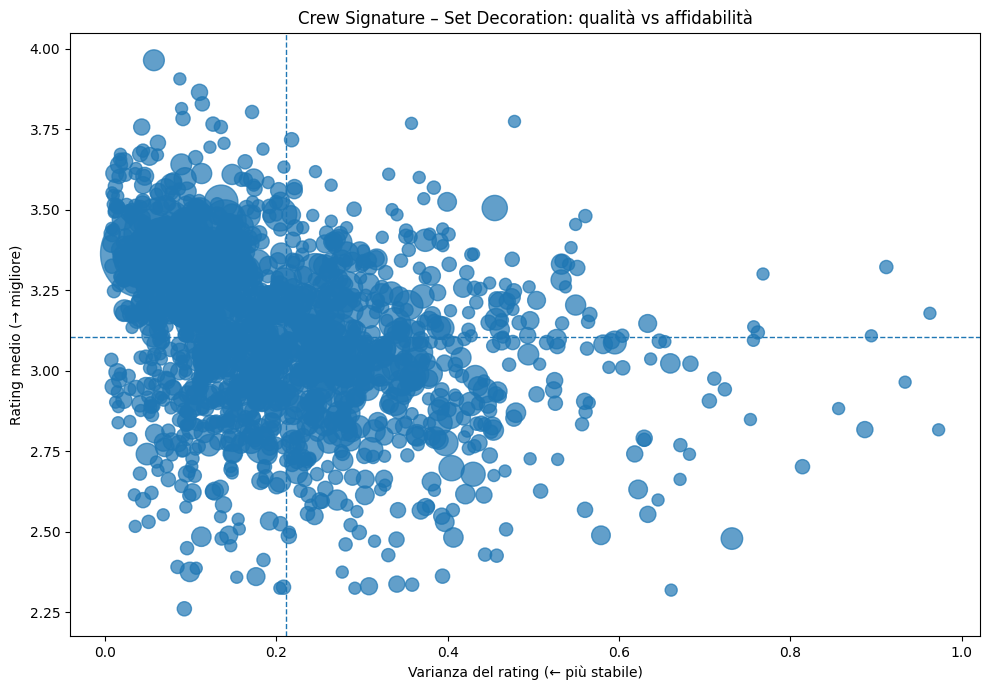

In [ ]:

setdecoration = crew_movies[crew_movies["role"] == "Set decoration"]

editor_signature = (
    setdecoration
    .groupby("name")
    .agg(
        n_films=("rating", "count"),
        mean_rating=("rating", "mean"),
        var_rating=("rating", "var")
    )
    .reset_index()
)

# Filtra solo editor con abbastanza film
MIN_FILMS = 5
sig = editor_signature[editor_signature["n_films"] >= MIN_FILMS]

plt.figure(figsize=(10, 7))

plt.scatter(
    sig["var_rating"],
    sig["mean_rating"],
    s=sig["n_films"] * 15,   # Dimensione punti in base al numero di film
    alpha=0.7
)

plt.xlabel("Varianza del rating (← più stabile)")
plt.ylabel("Rating medio (→ migliore)")
plt.title("Crew Signature – Set Decoration: qualità vs affidabilità")
plt.axhline(sig["mean_rating"].mean(), linestyle="--", linewidth=1)
plt.axvline(sig["var_rating"].mean(), linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


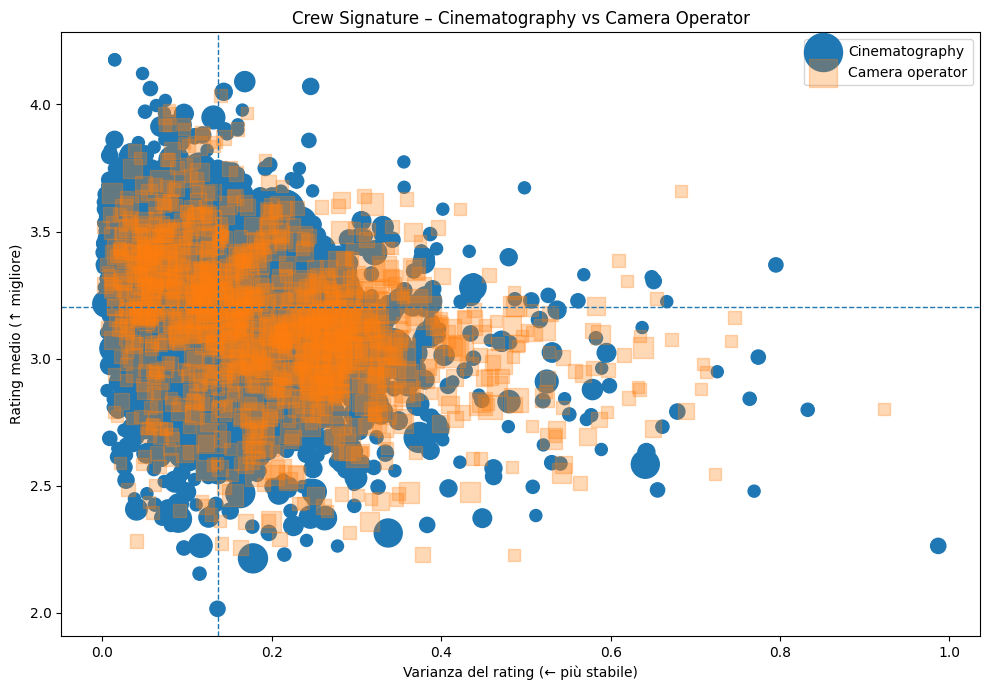

In [26]:

roles = ["Cinematography", "Camera operator"]

signatures = (
    crew_movies[crew_movies["role"].isin(roles)]
    .groupby(["role", "name"])
    .agg(
        n_films=("rating", "count"),
        mean_rating=("rating", "mean"),
        var_rating=("rating", "var")
    )
    .reset_index()
)

MIN_FILMS = 5
signatures = signatures[signatures["n_films"] >= MIN_FILMS]


plt.figure(figsize=(10, 7))

styles = {
    "Cinematography": {"marker": "o", "alpha": 1},
    "Camera operator": {"marker": "s", "alpha": 0.3}
}

for role, style in styles.items():
    subset = signatures[signatures["role"] == role]
    plt.scatter(
        subset["var_rating"],
        subset["mean_rating"],
        s=subset["n_films"] * 15, # Dimensione punti in base al numero di film
        label=role,
        marker=style["marker"],
        alpha=style["alpha"]
    )

# Linee di riferimento globali
plt.axhline(signatures["mean_rating"].mean(), linestyle="--", linewidth=1)
plt.axvline(signatures["var_rating"].mean(), linestyle="--", linewidth=1)

plt.xlabel("Varianza del rating (← più stabile)")
plt.ylabel("Rating medio (↑ migliore)")
plt.title("Crew Signature – Cinematography vs Camera Operator")
plt.legend()
plt.tight_layout()
plt.show()



L’analisi mostra che i ruoli tecnici hanno contributi diversi ma complementari: **Set Decoration e Lighting/Camera Operator** agiscono principalmente sulla **stabilità del risultato**, riducendo la probabilità di film negativi, mentre **Editor e Cinematography** incidono soprattutto sul **potenziale qualitativo massimo**, introducendo maggiore variabilità ma anche possibilità di eccellenza.
#### È quindi possibile affermare l’esistenza di una correlazione tra la composizione dello staff coinvolto nella produzione di un film e la sua riuscita in termini di recensioni positive; tale relazione risulta più evidente quando si considerano ruoli meno tecnici e più **autoriali**, il cui contributo tende a influenzare maggiormente l’esito qualitativo finale dell’opera.


## Analisi 5 – Career Shock Analysis  
### L’Oscar cambia davvero la carriera di un attore?

### Obiettivo
1) Analizzare l’evoluzione della carriera degli attori che hanno vinto almeno un Oscar, confrontando i film realizzati **prima e dopo** la prima vittoria.  
2) Valutare l’impatto dell’Oscar in termini di:
   - **qualità media** dei film (rating medio)
   - **andamento temporale** della carriera attorno all’evento di premiazione.  
3) Confrontare il comportamento degli **Oscar winners** con quello degli **attori non premiati**, utilizzati come gruppo di controllo.  
4) Verificare se l’Oscar rappresenti un fattore di **cambiamento strutturale** della carriera o piuttosto il riconoscimento di un **picco qualitativo già raggiunto**.

L’analisi non assume un effetto causale diretto del premio, ma utilizza un approccio di *shock temporale* per osservare eventuali variazioni sistematiche nelle traiettorie di carriera, distinguendo tra miglioramenti duraturi e semplici fenomeni di regressione verso la media.


In [100]:
# Actors nominati per un oscar
actors_oscar = actors.merge(
    the_oscar_awards,
    left_on=["name"],
    right_on=["name"],
    how="inner"
)

# Da qui voglio gli actors che hanno almeno un winner = true 
# Bisogna raggrupparli per .name anche
actors_oscar = actors_oscar[actors_oscar["winner"] == True].drop_duplicates(subset=["name"])

actors_oscar = actors_oscar.drop(columns=["role", "film", "category"])

actors_oscar.head()

,id,name,year_film,year_ceremony,ceremony,winner
9,1000001,Helen Mirren,2006,2007,79,True
12,1000001,Ann Roth,1996,1997,69,True
18,1000003,Michelle Yeoh,2022,2023,95,True
19,1000003,Ke Huy Quan,2022,2023,95,True
21,1000003,Jamie Lee Curtis,2022,2023,95,True


Rimangono solamente gli attori che hanno vinto almeno un oscar.

Valutiamo come il rating medio dei film interpretati da attori premiati varia nel tempo, centrando l’analisi sull’anno della vittoria (rel_year = 0) e considerando una finestra di ±10 anni.

In [101]:
# Rimangono solamente gli attori che hanno vinto almeno un oscar
actor_movies = (
    actors
    .merge(
        actors_oscar[["name", "year_film"]],   
        on="name",
        how="inner"
    )
    .merge(
        movies[["id", "rating", "date"]],
        on="id",
        how="inner"
    )
)

# Pulizia e anni
actor_movies = actor_movies.dropna(subset=["date", "rating", "year_film"])


actor_movies["year"] = actor_movies["date"].astype(int)
actor_movies["oscar_year"] = actor_movies["year_film"].astype(int)
actor_movies["rel_year"] = actor_movies["year"] - actor_movies["oscar_year"]

# finestra temporale [-10, +10]
actor_movies = actor_movies[
    (actor_movies["rel_year"] >= -10) &
    (actor_movies["rel_year"] <= 10)
]

# Aggregazione carriera media
career_trend = (
    actor_movies
    .groupby("rel_year")
    .agg(
        n_films=("id", "count"),
        mean_rating=("rating", "mean")
    )
    .reset_index()
)

career_trend


,rel_year,n_films,mean_rating
0,-10,263,3.370076
1,-9,295,3.352576
2,-8,312,3.301090
3,-7,356,3.310534
4,-6,332,3.309880
5,-5,392,3.325179
6,-4,402,3.312985
7,-3,442,3.340747
8,-2,447,3.330425
9,-1,447,3.335727


Otteniamo la media delle carriere di tutti gli attori che hanno vinto almeno un Oscar, allineate sull’anno della prima vittoria.

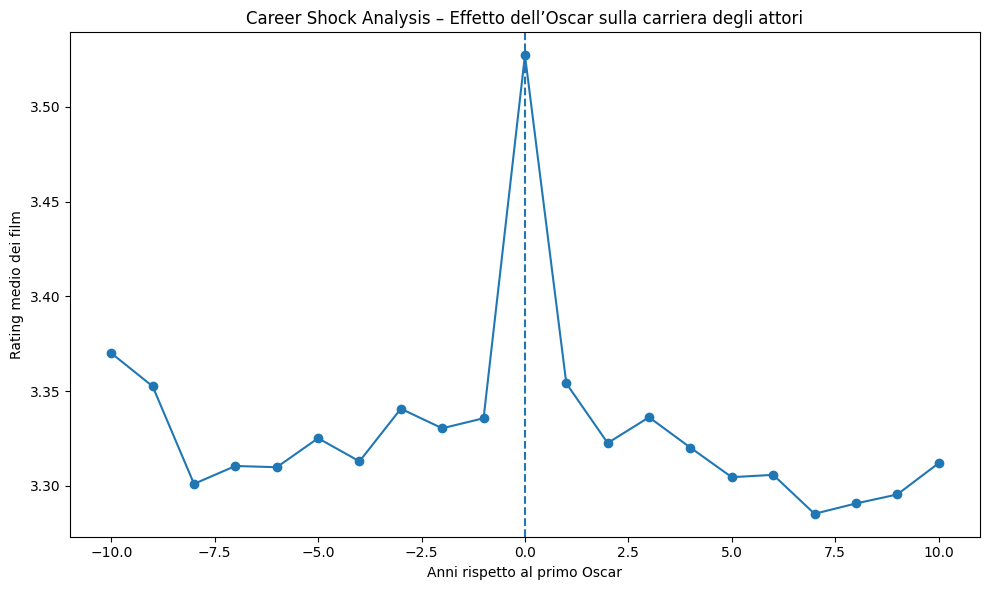

In [29]:
plt.figure(figsize=(10, 6))

plt.plot(
    career_trend["rel_year"],
    career_trend["mean_rating"],
    marker="o"
)

plt.axvline(0, linestyle="--")  # primo Oscar

plt.xlabel("Anni rispetto al primo Oscar")
plt.ylabel("Rating medio dei film")
plt.title("Career Shock Analysis – Effetto dell’Oscar sulla carriera degli attori")

plt.tight_layout()
plt.show()


Il grafico mostra il rating medio dei film interpretati da attori premiati in funzione degli anni rispetto alla loro prima vittoria dell’Oscar (t = 0).

Si osserva un picco netto nell’anno della vittoria, seguito da un rapido ritorno ai livelli precedenti, suggerendo un effetto concentrato e non persistente.
Il picco di rating nell’anno dell’Oscar indica che il premio arriva in un momento in cui la carriera dell’attore è già al massimo.
Dopo la vittoria non si osserva un miglioramento stabile dei film, segno che l’Oscar riconosce una qualità già raggiunta più che cambiarne davvero l’andamento futuro.



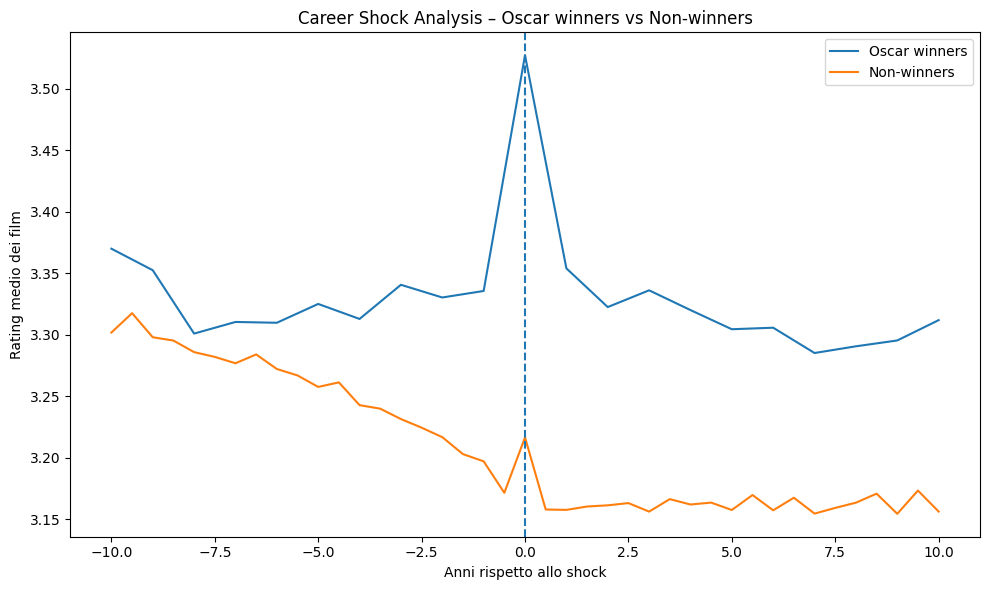

In [102]:
winners = actor_movies.copy()
winners["group"] = "Oscar winners"

# attori che NON hanno vinto un oscar
non_winners = (
    actors[~actors["name"].isin(actors_oscar["name"])]
    .merge(
        movies[["id", "rating", "date"]],
        on="id",
        how="inner"
    )
)

non_winners = non_winners.dropna(subset=["date", "rating"])
non_winners["year"] = non_winners["date"].astype(int)

# pseudo-shock = anno mediano della carriera dell’attore
median_year = (
    non_winners
    .groupby("name")["year"]
    .median()
    .reset_index(name="pseudo_year")
)

# uniamo per calcolare rel_year
non_winners = non_winners.merge(median_year, on="name", how="inner")
non_winners["rel_year"] = non_winners["year"] - non_winners["pseudo_year"]
non_winners["group"] = "Non-winners"

# stessa finestra temporale
non_winners = non_winners[
    (non_winners["rel_year"] >= -10) &
    (non_winners["rel_year"] <= 10)
]

# unione dei due gruppi
comparison = pd.concat([
    winners[["rel_year", "rating", "group"]],
    non_winners[["rel_year", "rating", "group"]]
])

trend = (
    comparison
    .groupby(["group", "rel_year"])
    .agg(mean_rating=("rating", "mean"))
    .reset_index()
)

plt.figure(figsize=(10, 6))

for grp in ["Oscar winners", "Non-winners"]:
    subset = trend[trend["group"] == grp]
    plt.plot(subset["rel_year"], subset["mean_rating"], label=grp)

plt.axvline(0, linestyle="--")

plt.xlabel("Anni rispetto allo shock")
plt.ylabel("Rating medio dei film")
plt.title("Career Shock Analysis – Oscar winners vs Non-winners")
plt.legend()
plt.tight_layout()
plt.show()


Il grafico confronta l’andamento del rating medio dei film per attori che hanno vinto un Oscar e attori che non lo hanno mai vinto, allineando le carriere rispetto a un evento temporale comune: il primo Oscar per i winners e un anno centrale della carriera per i non-winners.

Gli Oscar winners mostrano già prima della vittoria un rating medio più alto rispetto ai non-winners, indicando che il premio tende a riconoscere carriere in una fase positiva. Nell’anno della vittoria si osserva un picco netto, legato al film premiato, seguito da un rapido ritorno su valori simili a quelli precedenti.

Per i non-winners l’andamento è più regolare e privo di picchi evidenti, con variazioni contenute nel tempo.

Nel complesso, il confronto suggerisce che l’Oscar segnala un momento di alta qualità già raggiunto, ma non produce un miglioramento duraturo della qualità media dei film successivi.
